## Fetch Digital Humanities Publications from OpenAlex

In [48]:
import requests
import pandas as pd
import time

# OpenAlex API base URL
BASE_URL = "https://api.openalex.org/works"

# Query parameters to filter papers with "Digital Humanities" in the abstract
params = {
    "filter": "abstract.search:Digital Humanities",
    "per_page": 200  # Maximum allowed per request
}

all_papers = []  # List to store all fetched papers
next_cursor = "*"  # Start with initial cursor
page_count = 0
total_results = 0

# Add email for polite usage (OpenAlex recommends this)
email_header = {"User-Agent": "YOUR_EMAIL@example.com"}  # Replace with your email

# Loop through all pages using cursor-based pagination
while next_cursor:
    # Construct URL with cursor for pagination
    current_url = f"{BASE_URL}?filter=abstract.search:Digital+Humanities&per_page=200&cursor={next_cursor}"
    
    # Fetch data with polite headers
    response = requests.get(current_url, headers=email_header)
    
    if response.status_code == 200:
        data = response.json()
        papers = data.get("results", [])
        
        if papers:
            all_papers.extend(papers)
            page_count += 1
            
            # Get the meta section
            meta = data.get("meta", {})
            total_results = meta.get("count", 0)
            next_cursor = meta.get("next_cursor")
            
            # Print progress update
            print(f"Fetched page {page_count}, total papers so far: {len(all_papers)} of {total_results}")
            
            # Pause briefly to be nice to the API
            time.sleep(0.5)
        else:
            print("No papers found on this page.")
            break
    else:
        print(f"Error: {response.status_code}")
        break

# Convert the collected data to a DataFrame
if all_papers:
    print(f"Processing {len(all_papers)} papers...")
    
    # Create empty lists to collect paper data
    processed_papers = []
    
    for paper in all_papers:
        # Extract author names safely
        authors = []
        for authorship in paper.get("authorships", []):
            if "author" in authorship and "display_name" in authorship["author"]:
                authors.append(authorship["author"]["display_name"])
        
        # Extract concepts (subjects/fields) as a bonus
        concepts = []
        for concept in paper.get("concepts", [])[:3]:  # Get top 3 concepts
            if concept and "display_name" in concept:
                concepts.append(concept["display_name"])
        
        # Handle journal/venue safely (this is where the error occurred)
        journal_venue = None
        primary_location = paper.get("primary_location", {})
        if primary_location:
            source = primary_location.get("source")
            if source is not None:  # Check explicitly if source is not None
                journal_venue = source.get("display_name")
        
        # Create paper entry with additional fields
        paper_entry = {
            "Title": paper.get("title"),
            "Authors": authors,
            "Publication Year": paper.get("publication_year"),
            "Citations Count": paper.get("cited_by_count"),
            "DOI": paper.get("doi"),
            "OpenAlex ID": paper.get("id"),
            "Journal/Venue": journal_venue,
            "Concepts": concepts,
            "Open Access": paper.get("open_access", {}).get("is_oa", False)
        }
        
        processed_papers.append(paper_entry)
    
    # Convert to DataFrame
    df = pd.DataFrame(processed_papers)
    
    # Remove papers with missing citation counts if needed
    df = df[df["Citations Count"].notna()]
    
    # Display summary statistics
    print("\nSummary:")
    print(f"Total papers: {len(df)}")
    print(f"Year range: {df['Publication Year'].min()} - {df['Publication Year'].max()}")
    print(f"Most cited paper: {df.loc[df['Citations Count'].idxmax()]['Title']} with {df['Citations Count'].max()} citations")
    
    # Display first few rows
    print("\nFirst few entries:")
    print(df.head())
    
    # Save to CSV
    df.to_csv("Digital_Humanities_Papers.csv", index=False)
    print(f"\nSaved {len(df)} papers to 'Digital_Humanities_Papers.csv'.")
else:
    print("No papers found.")

Fetched page 1, total papers so far: 200 of 16302
Fetched page 2, total papers so far: 400 of 16302
Fetched page 3, total papers so far: 600 of 16302
Fetched page 4, total papers so far: 800 of 16302
Fetched page 5, total papers so far: 1000 of 16302
Fetched page 6, total papers so far: 1200 of 16302
Fetched page 7, total papers so far: 1400 of 16302
Fetched page 8, total papers so far: 1600 of 16302
Fetched page 9, total papers so far: 1800 of 16302
Fetched page 10, total papers so far: 2000 of 16302
Fetched page 11, total papers so far: 2200 of 16302
Fetched page 12, total papers so far: 2400 of 16302
Fetched page 13, total papers so far: 2600 of 16302
Fetched page 14, total papers so far: 2800 of 16302
Fetched page 15, total papers so far: 3000 of 16302
Fetched page 16, total papers so far: 3200 of 16302
Fetched page 17, total papers so far: 3400 of 16302
Fetched page 18, total papers so far: 3600 of 16302
Fetched page 19, total papers so far: 3800 of 16302
Fetched page 20, total pa

In [51]:
df = df[df["Citations Count"].notna()]
print(f"Remaining papers after filtering: {len(df)}")

Remaining papers after filtering: 16302


In [53]:
import pandas as pd
import requests
import time
import json
from tqdm import tqdm  # For progress bars

# Load your filtered DataFrame with papers that have citations
# If you're continuing from the previous script, you can skip this line
df = pd.read_csv("Digital_Humanities_Papers.csv")

# Initialize an empty list to store citation edges
citation_edges = []

# Set up polite headers for API requests
headers = {"User-Agent": "YOUR_EMAIL@example.com"}  # Replace with your email

# Function to fetch citing papers for a given work ID
def get_citing_papers(work_id):
    """Fetch papers that cite the given work ID."""
    # Base URL for the API
    url = f"https://api.openalex.org/works?filter=cites:{work_id}&per_page=200"
    
    # Make the request
    response = requests.get(url, headers=headers)
    
    # Check if the request was successful
    if response.status_code == 200:
        data = response.json()
        # Return list of citing paper IDs
        return [paper.get("id") for paper in data.get("results", [])]
    else:
        print(f"Error fetching citations for {work_id}: {response.status_code}")
        return []

# Display information about the process
print(f"Creating edge list for {len(df)} papers...")
print("This process may take some time depending on the number of papers.")

# Option 1: Process all papers (this can take a long time for large datasets)
for index, paper in tqdm(df.iterrows(), total=len(df)):
    paper_id = paper["OpenAlex ID"]
    
    # Skip if paper_id is missing
    if not paper_id:
        continue
    
    # Get papers that cite this paper
    citing_papers = get_citing_papers(paper_id)
    
    # Create edges (citing_paper -> cited_paper)
    for citing_paper_id in citing_papers:
        # Create an edge: source (citing paper) -> target (cited paper)
        citation_edges.append({
            "source": citing_paper_id,
            "target": paper_id
        })
    
    # Be nice to the API
    time.sleep(0.5)

# Option 2: For large datasets, consider using a sample of papers
# Uncomment these lines instead of the loop above if you have many papers
"""
# Sample a subset of papers (e.g., 100 most cited papers)
sample_df = df.sort_values(by="Citations Count", ascending=False).head(100)

for index, paper in tqdm(sample_df.iterrows(), total=len(sample_df)):
    paper_id = paper["OpenAlex ID"]
    
    # Same processing as above
    if not paper_id:
        continue
    
    citing_papers = get_citing_papers(paper_id)
    
    for citing_paper_id in citing_papers:
        citation_edges.append({
            "source": citing_paper_id,
            "target": paper_id
        })
    
    time.sleep(0.5)
"""

# Convert the edge list to a DataFrame
edges_df = pd.DataFrame(citation_edges)

# Display information about the created edge list
print(f"Created an edge list with {len(edges_df)} citation connections")
print(f"Number of unique source papers: {edges_df['source'].nunique()}")
print(f"Number of unique target papers: {edges_df['target'].nunique()}")

# Save the edge list to a CSV file
edges_df.to_csv("Digital_Humanities_Citation_Network.csv", index=False)
print("Saved edge list to 'Digital_Humanities_Citation_Network.csv'")

# Option: Create a more detailed edge list with paper metadata
# This creates a more informative network file with titles and years
detailed_edges = []

# Get metadata for papers in the network
all_paper_ids = set(edges_df["source"].tolist() + edges_df["target"].tolist())
paper_metadata = {}

print(f"Fetching metadata for {len(all_paper_ids)} papers in the network...")

# Fetch metadata in batches to be efficient with API calls
batch_size = 50
paper_id_batches = [list(all_paper_ids)[i:i+batch_size] for i in range(0, len(all_paper_ids), batch_size)]

for batch in tqdm(paper_id_batches):
    # Create comma-separated list of IDs for the filter
    ids_string = "|".join(batch)
    
    # Fetch data for this batch
    batch_url = f"https://api.openalex.org/works?filter=ids:{ids_string}&per_page={batch_size}"
    response = requests.get(batch_url, headers=headers)
    
    if response.status_code == 200:
        data = response.json()
        for paper in data.get("results", []):
            paper_id = paper.get("id")
            if paper_id:
                paper_metadata[paper_id] = {
                    "title": paper.get("title", "Unknown Title"),
                    "year": paper.get("publication_year"),
                    "citations": paper.get("cited_by_count", 0)
                }
    
    time.sleep(0.5)  # Be nice to the API

# Create detailed edge list with metadata
for _, edge in edges_df.iterrows():
    source_id = edge["source"]
    target_id = edge["target"]
    
    source_data = paper_metadata.get(source_id, {})
    target_data = paper_metadata.get(target_id, {})
    
    detailed_edges.append({
        "source_id": source_id,
        "source_title": source_data.get("title", "Unknown"),
        "source_year": source_data.get("year"),
        "source_citations": source_data.get("citations", 0),
        "target_id": target_id,
        "target_title": target_data.get("title", "Unknown"),
        "target_year": target_data.get("year"),
        "target_citations": target_data.get("citations", 0)
    })

# Create and save the detailed edge list
detailed_df = pd.DataFrame(detailed_edges)
detailed_df.to_csv("Digital_Humanities_Citation_Network_Detailed.csv", index=False)
print("Saved detailed edge list to 'Digital_Humanities_Citation_Network_Detailed.csv'")

Creating edge list for 16302 papers...
This process may take some time depending on the number of papers.


100%|██████████████████████████████████████████████████████████████████████████| 16302/16302 [4:45:00<00:00,  1.05s/it]


Created an edge list with 78394 citation connections
Number of unique source papers: 61026
Number of unique target papers: 7001
Saved edge list to 'Digital_Humanities_Citation_Network.csv'
Fetching metadata for 66275 papers in the network...


100%|██████████████████████████████████████████████████████████████████████████████| 1326/1326 [19:37<00:00,  1.13it/s]


Saved detailed edge list to 'Digital_Humanities_Citation_Network_Detailed.csv'


In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

# Load the edge list from the CSV file
# If you're continuing from the previous script, you can use edges_df directly
edges_df = pd.read_csv("Digital_Humanities_Citation_Network.csv")

# For the detailed edge list, if you created it
detailed_edges_df = pd.read_csv("Digital_Humanities_Citation_Network_Detailed.csv")

# Basic network analysis using networkx
print("Creating network from edge list...")
G = nx.from_pandas_edgelist(edges_df, 'source', 'target', create_using=nx.DiGraph())

# Basic network statistics
print("\nNetwork Statistics:")
print(f"Number of nodes (papers): {G.number_of_nodes()}")
print(f"Number of edges (citations): {G.number_of_edges()}")

# Calculate in-degree (times cited) and out-degree (references) for each node
in_degree = dict(G.in_degree())
out_degree = dict(G.out_degree())

# Convert to DataFrame for better analysis
degrees_df = pd.DataFrame({
    'paper_id': list(G.nodes()),
    'times_cited': [in_degree.get(node, 0) for node in G.nodes()],
    'references': [out_degree.get(node, 0) for node in G.nodes()]
})

# Calculate additional metrics
degrees_df['total_connections'] = degrees_df['times_cited'] + degrees_df['references']

# Sort by most cited papers
most_cited_df = degrees_df.sort_values('times_cited', ascending=False)

# Display the most cited papers
print("\nTop 10 Most Cited Papers in the Network:")
print(most_cited_df.head(10))

# Save the node degree information
degrees_df.to_csv("Digital_Humanities_Paper_Network_Metrics.csv", index=False)
print("\nSaved paper network metrics to 'Digital_Humanities_Paper_Network_Metrics.csv'")

# If you have the detailed edge list, join it with the network metrics
if 'detailed_edges_df' in locals():
    # Create a mapping from paper ID to paper title
    paper_titles = {}
    
    # From source papers
    for _, row in detailed_edges_df.iterrows():
        paper_titles[row['source_id']] = row['source_title']
    
    # From target papers
    for _, row in detailed_edges_df.iterrows():
        paper_titles[row['target_id']] = row['target_title']
    
    # Add titles to the degrees DataFrame
    degrees_df['title'] = degrees_df['paper_id'].map(lambda x: paper_titles.get(x, "Unknown Title"))
    
    # Create a more complete dataset
    enhanced_df = degrees_df[['paper_id', 'title', 'times_cited', 'references', 'total_connections']]
    
    # Save the enhanced dataset
    enhanced_df.to_csv("Digital_Humanities_Paper_Network_Enhanced.csv", index=False)
    print("Saved enhanced paper metrics to 'Digital_Humanities_Paper_Network_Enhanced.csv'")

# Optional: Calculate and analyze network communities
try:
    # This can take time for large networks
    print("\nDetecting communities in the network...")
    communities = nx.community.greedy_modularity_communities(G.to_undirected())
    
    print(f"Detected {len(communities)} communities")
    print(f"Sizes of the 5 largest communities: {[len(c) for c in list(communities)[:5]]}")
    
    # Add community information to the dataframe
    community_map = {}
    for i, community in enumerate(communities):
        for node in community:
            community_map[node] = i
    
    # Add community to the degrees dataframe
    degrees_df['community'] = degrees_df['paper_id'].map(lambda x: community_map.get(x, -1))
    
    # Save updated dataframe with community information
    degrees_df.to_csv("Digital_Humanities_Paper_Network_With_Communities.csv", index=False)
    print("Saved network data with community detection to 'Digital_Humanities_Paper_Network_With_Communities.csv'")
except Exception as e:
    print(f"Could not perform community detection: {e}")

# Optional: Create a visualization of the network
# Note: This may not work well for very large networks
try:
    if G.number_of_nodes() <= 1000:  # Only attempt for reasonably sized networks
        print("\nCreating network visualization...")
        plt.figure(figsize=(12, 10))
        
        # Use a force-directed layout
        pos = nx.spring_layout(G, k=0.1, iterations=50)
        
        # Size nodes by their in-degree (times cited)
        node_size = [10 + 3 * in_degree.get(node, 0) for node in G.nodes()]
        
        # Draw the network
        nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='lightblue', alpha=0.8)
        nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.5, arrows=False)  # No arrows for cleaner viz
        
        plt.title("Digital Humanities Citation Network")
        plt.axis('off')
        
        # Save the visualization
        plt.savefig("Digital_Humanities_Citation_Network.png", dpi=300, bbox_inches='tight')
        print("Saved network visualization to 'Digital_Humanities_Citation_Network.png'")
        
        plt.close()
except Exception as e:
    print(f"Could not create visualization: {e}")

print("\nAnalysis complete!")

Creating network from edge list...

Network Statistics:
Number of nodes (papers): 66275
Number of edges (citations): 78394

Top 10 Most Cited Papers in the Network:
                               paper_id  times_cited  references  \
55968  https://openalex.org/W3041064909          200           0   
18576  https://openalex.org/W2292809381          200           0   
403    https://openalex.org/W2300567117          200           0   
27412  https://openalex.org/W2996994624          200           0   
16485  https://openalex.org/W1506026338          200           0   
603     https://openalex.org/W584790758          200           0   
40635  https://openalex.org/W3036646185          200           0   
24589   https://openalex.org/W936584304          200           0   
202     https://openalex.org/W419149097          200           0   
2163    https://openalex.org/W586916919          200           0   

       total_connections  
55968                200  
18576                200  
403  

Loading citation network data...
Network loaded with 66275 papers and 78394 citation links
Computing PageRank scores...
Attempting to load detailed paper information...
Saved PageRank scores to 'Digital_Humanities_PageRank_Scores.csv'

Top 20 Most Influential Papers by PageRank:
    pagerank_rank                          paper_id    title  pagerank_score  citation_count  citation_rank
0               1  https://openalex.org/W3141641508  Unknown        0.003841             165           78.0
1               2  https://openalex.org/W1504287823  Unknown        0.003211             200            1.0
2               3    https://openalex.org/W62784252  Unknown        0.002965             200            1.0
3               4   https://openalex.org/W419149097  Unknown        0.002853             200            1.0
4               5  https://openalex.org/W2112031167  Unknown        0.002570             200            1.0
5               6  https://openalex.org/W1526733779  Unknown        0.00

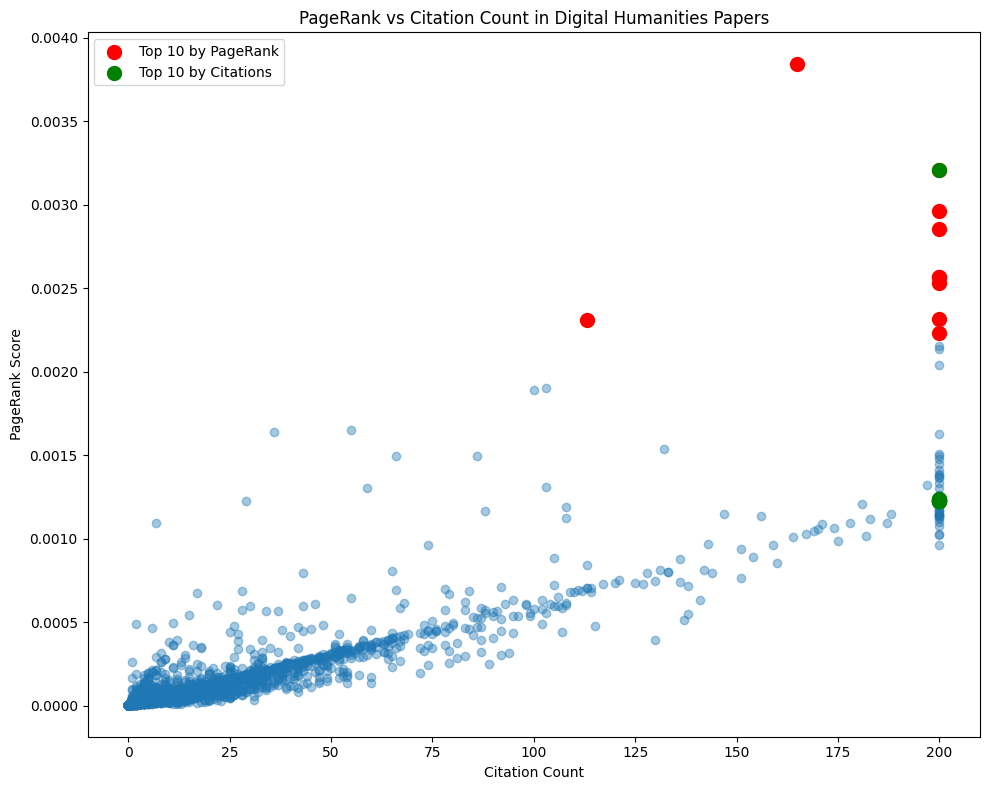

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Load the edge list from the CSV file
print("Loading citation network data...")
edges_df = pd.read_csv("Digital_Humanities_Citation_Network.csv")

# Create a directed graph from the edge list
# Note: In citation networks, edges typically go from citing paper (source) to cited paper (target)
G = nx.from_pandas_edgelist(edges_df, 'source', 'target', create_using=nx.DiGraph())

print(f"Network loaded with {G.number_of_nodes()} papers and {G.number_of_edges()} citation links")

# Compute PageRank scores for the network
print("Computing PageRank scores...")
pagerank_scores = nx.pagerank(G, alpha=0.85, max_iter=100)

# Convert PageRank scores to a DataFrame
pagerank_df = pd.DataFrame({
    'paper_id': list(pagerank_scores.keys()),
    'pagerank_score': list(pagerank_scores.values())
})

# Sort by PageRank score (descending)
pagerank_df = pagerank_df.sort_values('pagerank_score', ascending=False).reset_index(drop=True)

# Add rank column
pagerank_df['pagerank_rank'] = pagerank_df.index + 1

# Also compute in-degree (citation count in the network)
in_degree = dict(G.in_degree())
pagerank_df['citation_count'] = pagerank_df['paper_id'].map(lambda x: in_degree.get(x, 0))
pagerank_df['citation_rank'] = pagerank_df['citation_count'].rank(method='min', ascending=False)

# Try to load detailed paper information if available
try:
    print("Attempting to load detailed paper information...")
    # Try loading from the enhanced network file if it exists
    detailed_df = pd.read_csv("Digital_Humanities_Paper_Network_Enhanced.csv")
    paper_info = detailed_df[['paper_id', 'title']].set_index('paper_id').to_dict()['title']
    pagerank_df['title'] = pagerank_df['paper_id'].map(lambda x: paper_info.get(x, "Unknown Title"))
except FileNotFoundError:
    print("Detailed paper information not found. Fetching titles for top papers...")
    # If detailed info isn't available, try to fetch titles for the top papers
    try:
        import requests
        import time
        
        # Only fetch titles for top 100 papers to be efficient
        top_papers = pagerank_df.head(100)['paper_id'].tolist()
        
        # Function to fetch paper title from OpenAlex
        def get_paper_title(paper_id):
            url = f"https://api.openalex.org/works/{paper_id}"
            response = requests.get(url, headers={"User-Agent": "YOUR_EMAIL@example.com"})
            if response.status_code == 200:
                data = response.json()
                return data.get("title", "Unknown Title")
            return "Unknown Title"
        
        # Fetch titles for top papers
        titles = {}
        for paper_id in tqdm(top_papers, desc="Fetching paper titles"):
            titles[paper_id] = get_paper_title(paper_id)
            time.sleep(0.5)  # Be nice to the API
        
        # Add titles to the DataFrame
        pagerank_df['title'] = pagerank_df['paper_id'].map(lambda x: titles.get(x, "Unknown Title"))
    except ImportError:
        print("Requests library not available. Proceeding without paper titles.")
        pagerank_df['title'] = "Title not available"

# Save the PageRank scores to a CSV file
pagerank_df.to_csv("Digital_Humanities_PageRank_Scores.csv", index=False)
print("Saved PageRank scores to 'Digital_Humanities_PageRank_Scores.csv'")

# Display the top influential papers by PageRank
print("\nTop 20 Most Influential Papers by PageRank:")
top_papers = pagerank_df.head(20)[['pagerank_rank', 'paper_id', 'title', 'pagerank_score', 'citation_count', 'citation_rank']]
print(top_papers.to_string())

# Create a comparison between PageRank ranking and citation count ranking
print("\nComparing PageRank vs. Citation Count Rankings:")

# Calculate the differences between rankings
pagerank_df['rank_difference'] = pagerank_df['citation_rank'] - pagerank_df['pagerank_rank']

# Find papers that are ranked much higher by PageRank than by citation count
# These are papers that might be underappreciated if only looking at citation counts
underappreciated_papers = pagerank_df[pagerank_df['rank_difference'] > 50].sort_values('rank_difference', ascending=False).head(10)
print("\nPapers ranked much higher by PageRank than by raw citation count:")
print(underappreciated_papers[['paper_id', 'title', 'pagerank_rank', 'citation_rank', 'rank_difference']].to_string())

# Find papers that are ranked much higher by citation count than by PageRank
# These are papers that might be overappreciated if only looking at citation counts
overappreciated_papers = pagerank_df[pagerank_df['rank_difference'] < -50].sort_values('rank_difference').head(10)
print("\nPapers ranked much higher by raw citation count than by PageRank:")
print(overappreciated_papers[['paper_id', 'title', 'pagerank_rank', 'citation_rank', 'rank_difference']].to_string())

# Create a visualization comparing PageRank and citation counts
plt.figure(figsize=(10, 8))
plt.scatter(pagerank_df['citation_count'], pagerank_df['pagerank_score'], alpha=0.4)

# Highlight top papers by PageRank
top_by_pagerank = pagerank_df.head(10)
plt.scatter(top_by_pagerank['citation_count'], top_by_pagerank['pagerank_score'], 
           color='red', s=100, label='Top 10 by PageRank')

# Highlight top papers by citation count
top_by_citations = pagerank_df.sort_values('citation_count', ascending=False).head(10)
plt.scatter(top_by_citations['citation_count'], top_by_citations['pagerank_score'], 
           color='green', s=100, label='Top 10 by Citations')

plt.xlabel('Citation Count')
plt.ylabel('PageRank Score')
plt.title('PageRank vs Citation Count in Digital Humanities Papers')
plt.legend()
plt.tight_layout()
plt.savefig('Digital_Humanities_PageRank_vs_Citations.png', dpi=300)
print("Saved visualization to 'Digital_Humanities_PageRank_vs_Citations.png'")

# Optional: Generate a summary of the PageRank analysis
summary = f"""
# PageRank Analysis of Digital Humanities Citation Network

## Network Overview
- Total papers (nodes): {G.number_of_nodes()}
- Total citations (edges): {G.number_of_edges()}

## PageRank Results
- Highest PageRank score: {pagerank_df['pagerank_score'].max():.6f}
- Average PageRank score: {pagerank_df['pagerank_score'].mean():.6f}
- Median PageRank score: {pagerank_df['pagerank_score'].median():.6f}

## Top 5 Most Influential Papers by PageRank
{pagerank_df.head(5)[['pagerank_rank', 'title', 'pagerank_score', 'citation_count']].to_string(index=False)}

## Correlation Analysis
- Correlation between PageRank and citation count: {pagerank_df['pagerank_score'].corr(pagerank_df['citation_count']):.4f}

## Key Insights
- Papers ranked significantly higher by PageRank than by citation count may represent works that have influenced important papers but are not as widely cited overall.
- Papers with high citation counts but lower PageRank scores may be popular but cite fewer influential works in the field.
"""

# Save the summary to a file
with open('Digital_Humanities_PageRank_Analysis_Summary.md', 'w') as f:
    f.write(summary)

print("\nAnalysis complete! Summary saved to 'Digital_Humanities_PageRank_Analysis_Summary.md'")

Saved citation distribution to 'Digital_Humanities_Citation_Distribution.png'

Temporal analysis requires publication year data which is not available in your current dataset.
To perform temporal analysis, you need to:
1. Obtain publication years for papers in your network
2. Add this data to your 'Digital_Humanities_Paper_Network_Enhanced.csv' file
3. Re-run this script to generate temporal visualizations


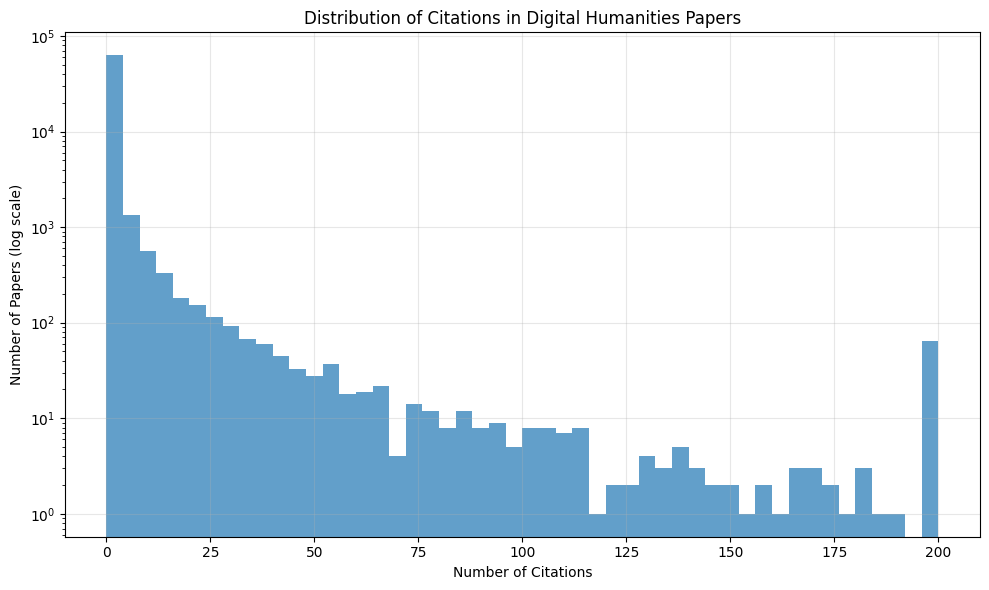

In [3]:
# Add this after your existing visualization code

# 1. Citation Distribution Visualization
plt.figure(figsize=(10, 6))
plt.hist(pagerank_df['citation_count'], bins=50, log=True, alpha=0.7)
plt.xlabel('Number of Citations')
plt.ylabel('Number of Papers (log scale)')
plt.title('Distribution of Citations in Digital Humanities Papers')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('Digital_Humanities_Citation_Distribution.png', dpi=300)
print("Saved citation distribution to 'Digital_Humanities_Citation_Distribution.png'")

# 2. Temporal Analysis of Citations
# Note: This requires publication date information which is not in your current data
# Check if we have year information in the detailed data
has_year_data = False

try:
    if 'detailed_df' in locals() and 'year' in detailed_df.columns:
        # If we already loaded detailed data and it has year information
        has_year_data = True
        year_data = detailed_df[['paper_id', 'year']].dropna()
        
        # Merge with pagerank data
        temporal_df = pagerank_df.merge(year_data, on='paper_id', how='inner')
        
        # Group by year and calculate statistics
        yearly_stats = temporal_df.groupby('year').agg({
            'paper_id': 'count',
            'citation_count': ['mean', 'median', 'sum']
        }).reset_index()
        
        yearly_stats.columns = ['year', 'paper_count', 'avg_citations', 'median_citations', 'total_citations']
        
        # Plotting temporal trends
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
        
        # Plot 1: Number of papers per year
        ax1.bar(yearly_stats['year'], yearly_stats['paper_count'], color='skyblue', alpha=0.7)
        ax1.set_ylabel('Number of Papers')
        ax1.set_title('Digital Humanities Publications by Year')
        ax1.grid(alpha=0.3)
        
        # Plot 2: Citation metrics by year
        ax2.plot(yearly_stats['year'], yearly_stats['avg_citations'], marker='o', label='Average Citations')
        ax2.plot(yearly_stats['year'], yearly_stats['median_citations'], marker='s', label='Median Citations')
        ax2.set_xlabel('Year')
        ax2.set_ylabel('Citations per Paper')
        ax2.set_title('Citation Metrics by Publication Year')
        ax2.legend()
        ax2.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('Digital_Humanities_Temporal_Citation_Analysis.png', dpi=300)
        print("Saved temporal citation analysis to 'Digital_Humanities_Temporal_Citation_Analysis.png'")
    else:
        has_year_data = False
except:
    has_year_data = False

# If we don't have year data in the detailed dataframe
if not has_year_data:
    print("\nTemporal analysis requires publication year data which is not available in your current dataset.")
    print("To perform temporal analysis, you need to:")
    print("1. Obtain publication years for papers in your network")
    print("2. Add this data to your 'Digital_Humanities_Paper_Network_Enhanced.csv' file")
    print("3. Re-run this script to generate temporal visualizations")

Loading paper metadata with publication years...
Adding publication years to the analysis...
Papers with publication years: 7772 out of 66275 (11.7%)

Performing temporal analysis of citations...
Saved citation distribution to 'Digital_Humanities_Citation_Distribution.png'
Saved temporal citation analysis to 'Digital_Humanities_Temporal_Citation_Analysis.png'
Saved yearly statistics to 'Digital_Humanities_Yearly_Statistics.csv'


C:\Users\AMAN\AppData\Local\Temp\ipykernel_22896\3153236194.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_edges['source_year'] = valid_edges['source_year'].astype(int)
C:\Users\AMAN\AppData\Local\Temp\ipykernel_22896\3153236194.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_edges['target_year'] = valid_edges['target_year'].astype(int)


Saved citation heatmap to 'Digital_Humanities_Citation_Heatmap.png'


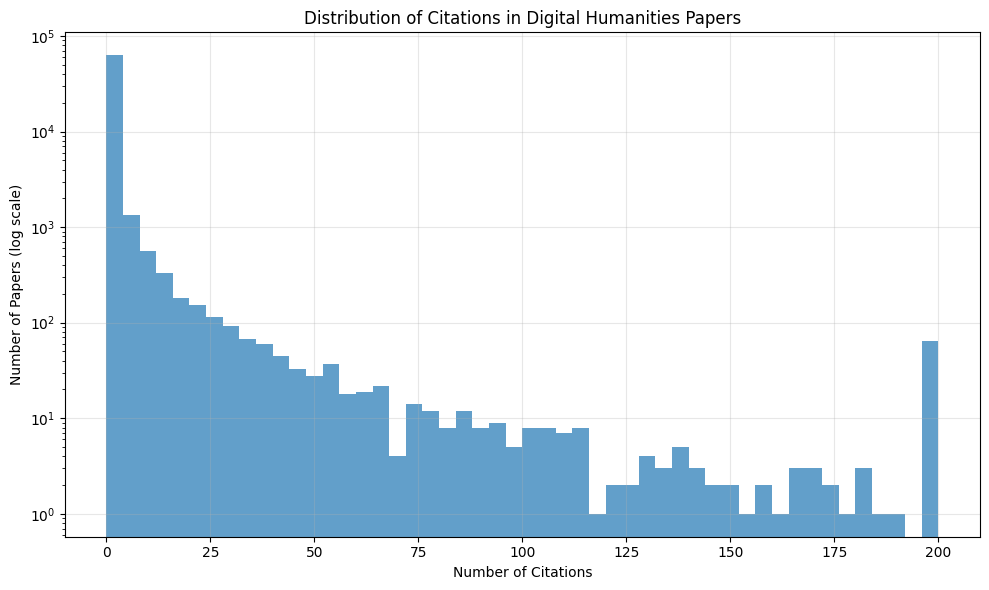

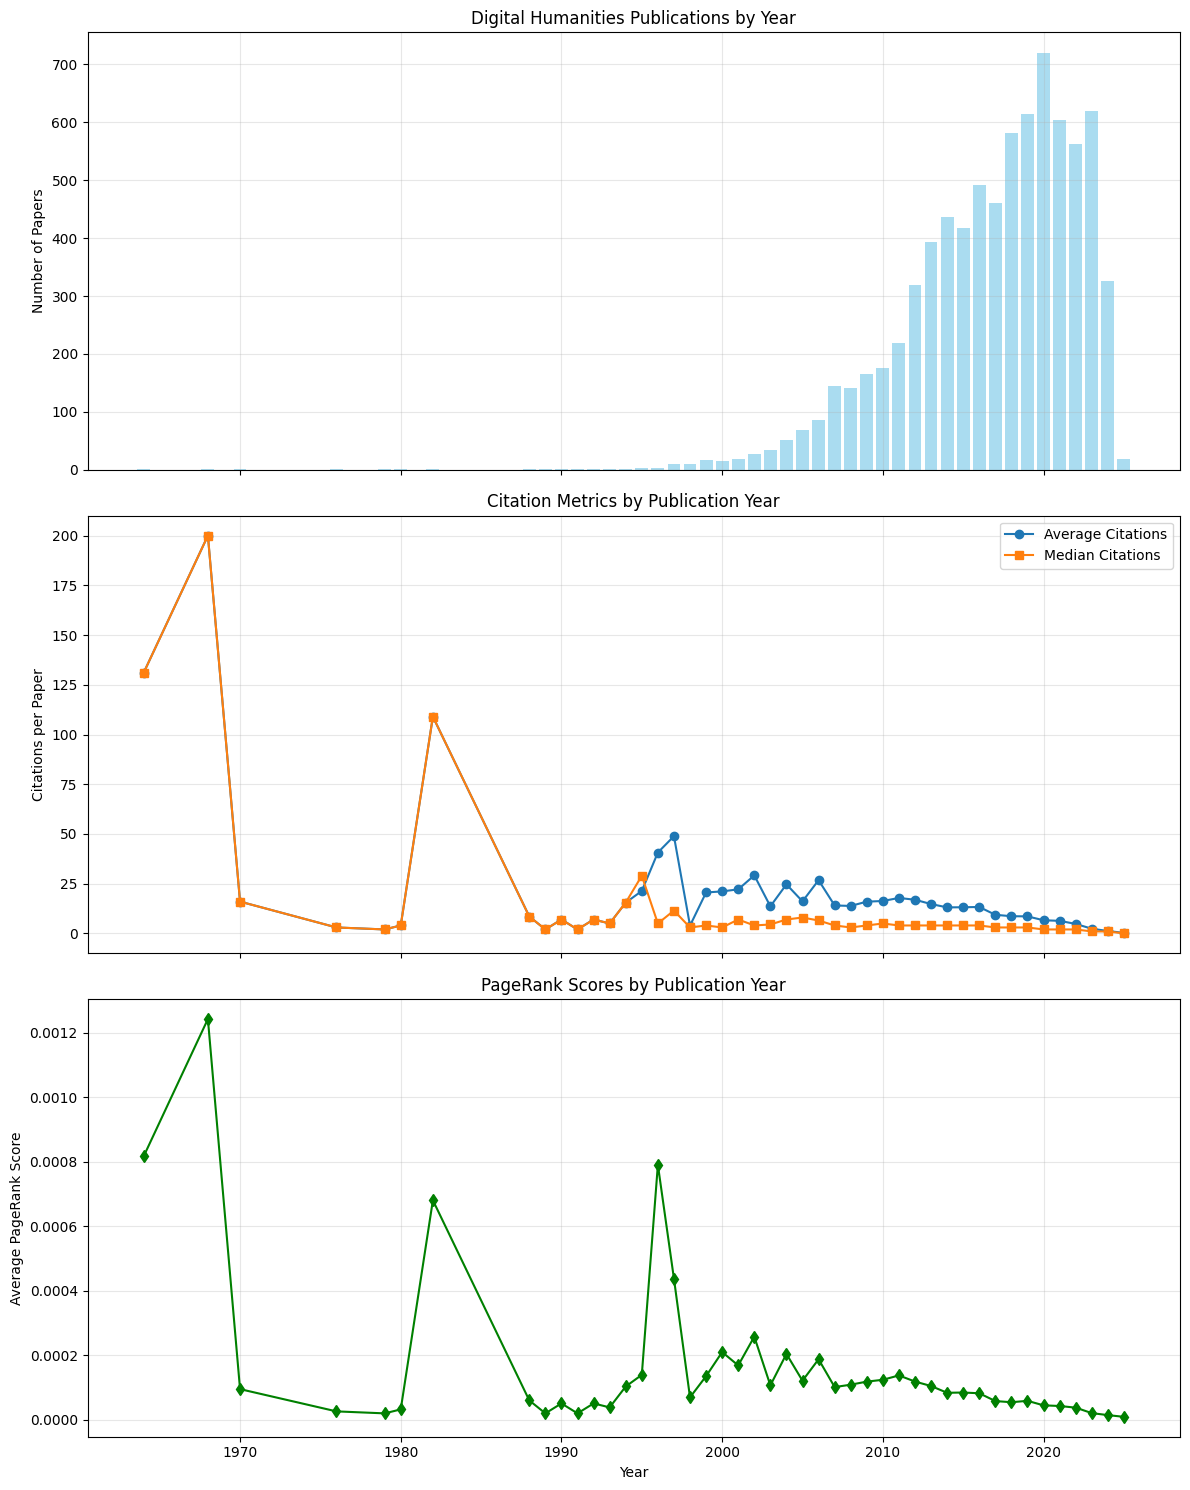

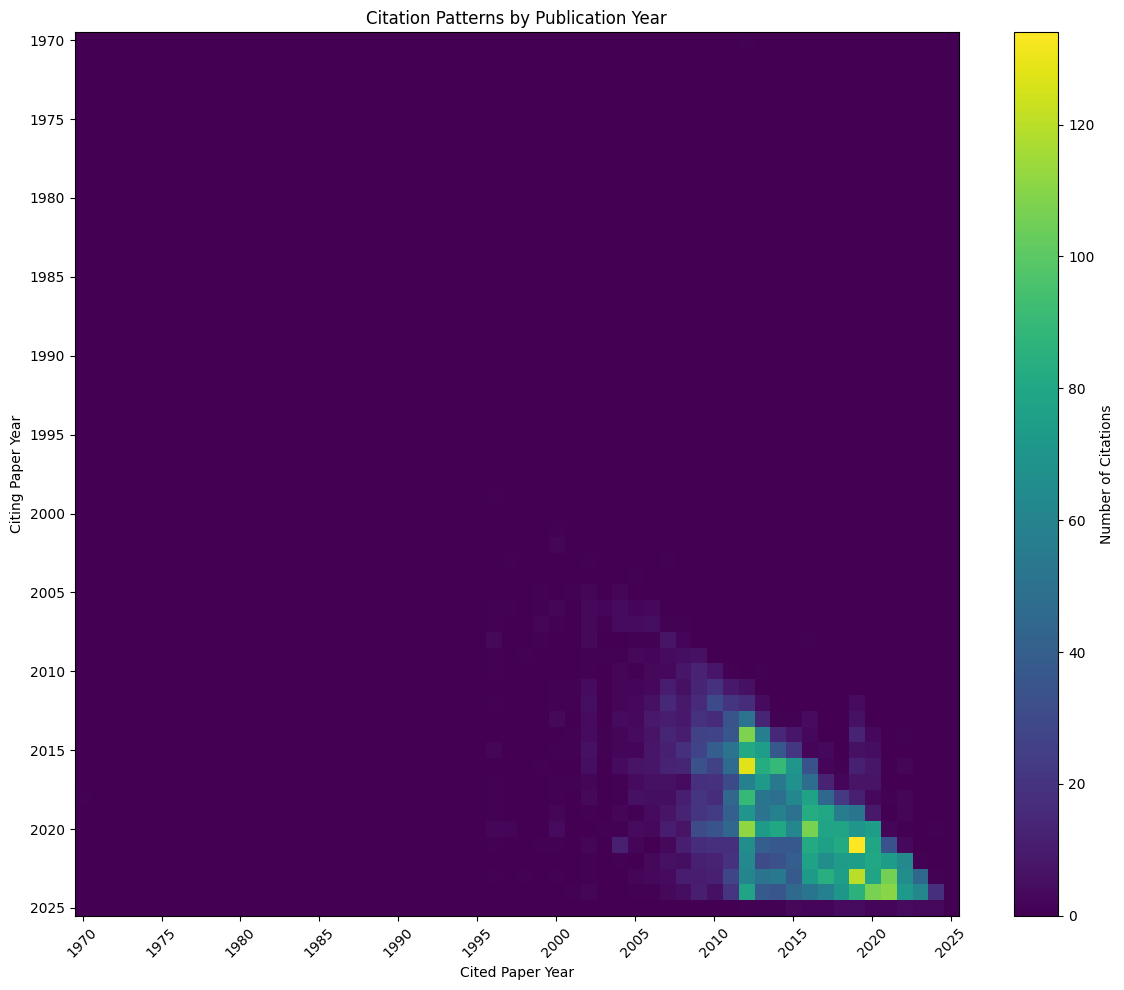

In [6]:
# Add this code after loading your citation network but before your analysis
# This should replace the previous integration attempt

# Load the paper metadata that includes publication years
print("Loading paper metadata with publication years...")
papers_df = pd.read_csv("Digital_Humanities_Papers.csv")

# Create a mapping of OpenAlex IDs to publication years
# Since both datasets use the same ID format, we can use direct mapping
year_mapping = dict(zip(papers_df['OpenAlex ID'], papers_df['Publication Year']))

# Add publication years to your PageRank DataFrame
print("Adding publication years to the analysis...")
pagerank_df['publication_year'] = pagerank_df['paper_id'].map(year_mapping)

# Check how many papers have years
papers_with_years = pagerank_df['publication_year'].notna().sum()
print(f"Papers with publication years: {papers_with_years} out of {len(pagerank_df)} ({papers_with_years/len(pagerank_df)*100:.1f}%)")

# Now add the temporal analysis code
print("\nPerforming temporal analysis of citations...")

# Filter to papers with valid publication years
temporal_df = pagerank_df[pagerank_df['publication_year'].notna()].copy()

if len(temporal_df) > 0:
    # Convert publication year to integer
    temporal_df['publication_year'] = temporal_df['publication_year'].astype(int)
    
    # 1. Citation Distribution Visualization (for all papers)
    plt.figure(figsize=(10, 6))
    plt.hist(pagerank_df['citation_count'], bins=50, log=True, alpha=0.7)
    plt.xlabel('Number of Citations')
    plt.ylabel('Number of Papers (log scale)')
    plt.title('Distribution of Citations in Digital Humanities Papers')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('Digital_Humanities_Citation_Distribution.png', dpi=300)
    print("Saved citation distribution to 'Digital_Humanities_Citation_Distribution.png'")
    
    # 2. Temporal Analysis
    # Group by year and calculate statistics
    yearly_stats = temporal_df.groupby('publication_year').agg({
        'paper_id': 'count',
        'citation_count': ['mean', 'median', 'sum'],
        'pagerank_score': ['mean', 'max']
    }).reset_index()
    
    # Fix column names after aggregation
    yearly_stats.columns = ['year', 'paper_count', 'avg_citations', 'median_citations', 
                           'total_citations', 'avg_pagerank', 'max_pagerank']
    
    # Plotting temporal trends
    fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
    
    # Plot 1: Number of papers per year
    axes[0].bar(yearly_stats['year'], yearly_stats['paper_count'], color='skyblue', alpha=0.7)
    axes[0].set_ylabel('Number of Papers')
    axes[0].set_title('Digital Humanities Publications by Year')
    axes[0].grid(alpha=0.3)
    
    # Plot 2: Citation metrics by year
    axes[1].plot(yearly_stats['year'], yearly_stats['avg_citations'], marker='o', 
                label='Average Citations')
    axes[1].plot(yearly_stats['year'], yearly_stats['median_citations'], marker='s', 
                label='Median Citations')
    axes[1].set_ylabel('Citations per Paper')
    axes[1].set_title('Citation Metrics by Publication Year')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    # Plot 3: PageRank scores by year
    axes[2].plot(yearly_stats['year'], yearly_stats['avg_pagerank'], marker='d', 
                color='green', label='Average PageRank')
    axes[2].set_xlabel('Year')
    axes[2].set_ylabel('Average PageRank Score')
    axes[2].set_title('PageRank Scores by Publication Year')
    axes[2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('Digital_Humanities_Temporal_Citation_Analysis.png', dpi=300)
    print("Saved temporal citation analysis to 'Digital_Humanities_Temporal_Citation_Analysis.png'")
    
    # Save yearly statistics to CSV
    yearly_stats.to_csv('Digital_Humanities_Yearly_Statistics.csv', index=False)
    print("Saved yearly statistics to 'Digital_Humanities_Yearly_Statistics.csv'")
    
    # 3. Additional visualization: Cited vs Citing year analysis (if edge data is available)
    if 'edges_df' in locals() and not edges_df.empty:
        try:
            # Add publication years to the edge data
            edges_df['source_year'] = edges_df['source'].map(year_mapping)
            edges_df['target_year'] = edges_df['target'].map(year_mapping)
            
            # Filter to edges with valid years
            valid_edges = edges_df.dropna(subset=['source_year', 'target_year'])
            
            if len(valid_edges) > 0:
                valid_edges['source_year'] = valid_edges['source_year'].astype(int)
                valid_edges['target_year'] = valid_edges['target_year'].astype(int)
                
                # Create a year range for our heatmap
                min_year = min(valid_edges['source_year'].min(), valid_edges['target_year'].min())
                max_year = max(valid_edges['source_year'].max(), valid_edges['target_year'].max())
                year_range = list(range(min_year, max_year + 1))
                
                # Create a matrix to count citations from year X to year Y
                citation_matrix = np.zeros((len(year_range), len(year_range)))
                
                # Group and count citations by source and target year
                citation_counts = valid_edges.groupby(['source_year', 'target_year']).size().reset_index(name='count')
                
                # Fill the matrix
                for _, row in citation_counts.iterrows():
                    source_idx = year_range.index(int(row['source_year']))
                    target_idx = year_range.index(int(row['target_year']))
                    citation_matrix[source_idx, target_idx] = row['count']
                
                # Plot the heatmap
                plt.figure(figsize=(12, 10))
                plt.imshow(citation_matrix, cmap='viridis', aspect='auto')
                plt.colorbar(label='Number of Citations')
                plt.xlabel('Cited Paper Year')
                plt.ylabel('Citing Paper Year')
                plt.title('Citation Patterns by Publication Year')
                
                # Add year labels
                step = max(1, len(year_range) // 10)  # Show at most 10 labels to avoid crowding
                plt.xticks(range(0, len(year_range), step), year_range[::step], rotation=45)
                plt.yticks(range(0, len(year_range), step), year_range[::step])
                
                plt.tight_layout()
                plt.savefig('Digital_Humanities_Citation_Heatmap.png', dpi=300)
                print("Saved citation heatmap to 'Digital_Humanities_Citation_Heatmap.png'")
        except Exception as e:
            print(f"Could not create citation pattern heatmap: {str(e)}")
            
else:
    print("Could not perform temporal analysis: No papers with valid publication years found")